In [1]:
# %matplotlib notebook
# %matplotlib inline
import numpy as np
np.random.seed(123)
import collections, copy, pickle
from importlib import reload
from dateutil.parser import parse
import scipy.linalg, scipy.stats
import pandas as pd
import sklearn
# import scipy.sparse
# import scipy.sparse.linalg
# import matplotlib
# import matplotlib.transforms
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
# import mpl_toolkits.mplot3d.axes3d as p3
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# from matplotlib import animation
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
# rcParams['text.usetex'] = True
import seaborn as sns
from IPython.display import HTML
# from numba import jit, njit, float32, prange
# import cProfile

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [3]:
import util.plot
import util.data

In [4]:
reload(util.plot)
reload(util.data)

<module 'util.data' from '/Users/mark/stack/doc/school/Data Mining Techniques/lab/util/data.py'>

In [5]:
data = pd.read_csv('ODI-2019-csv.csv', sep=';')

In [6]:
for i in range(len(data.index)):
    n = data.iloc[i].isnull().sum()
    if n > 0:
        print("Nan in row ", i ,  data.keys()[i])

Nan in row  0 Timestamp


In [7]:
# key = 'What programme are you in?'
# data[data[key].isin(['CLS','COMPUTATIONAL SCIENCE'])]

There is a single missing value (in the first row)

In [8]:
data.iloc[0][-1:]

What is your stress level (0-100)?    NaN
Name: 0, dtype: object

Generate a clean db with
```
python3 clean_odi.py
```

In [9]:
# %ls

In [10]:
data = pd.read_csv('ODI-2019-clean.csv', sep=';')

In [11]:
data.describe()

,Unnamed: 0,Stress level,Day,Month,Year,Neighbours,Money
count,276.000000,276.000000,262.000000,262.000000,201.000000,261.000000,276.000000
mean,137.500000,38.500000,14.419847,6.419847,1993.985075,4.877395,35.241884
std,79.818544,33.933571,8.503733,3.411619,3.464791,8.174556,40.238578
min,0.000000,0.000000,0.000000,0.000000,1969.000000,0.000000,0.000000
25%,68.750000,10.000000,8.000000,4.000000,1993.000000,2.000000,1.000000
50%,137.500000,30.000000,13.000000,6.000000,1995.000000,3.000000,10.000000
75%,206.250000,65.000000,21.000000,9.000000,1996.000000,6.000000,80.000000
max,275.000000,100.000000,31.000000,12.000000,2001.000000,80.000000,100.000000


In [12]:
data.head()

,Unnamed: 0,Timestamp,ML,IR,Stat,DB,Gender,Chocolate,Stand Up,Rand,Good day (1),Good day (2),Stress level,Programme,Day,Month,Year,Neighbours,Money,Bedtime
0,0,3/27/2019 10:16:11,Yes,Yes,Yes,Yes,unknown,Slim,no,6,sun,lecture,30.0,AI,NaN,NaN,NaN,3.0,100.0,23:00:00
1,1,4/1/2019 15:58:21,No,No,Yes,Yes,male,Fat,no,7,DM,AI,1.0,AI,9.0,7.0,1992.0,1.0,0.0,03:00:00
2,2,4/1/2019 15:59:07,Yes,Yes,Unknown,Yes,male,Neither,unknown,0,0,0,100.0,CS,4.0,8.0,1995.0,0.0,0.0,00:00:00
3,3,4/1/2019 15:59:30,Yes,Yes,Yes,Yes,male,Fat,no,"1,645",Winning,Food,0.0,CS,29.0,9.0,1993.0,2.0,42.0,00:30:00
4,4,4/1/2019 15:59:58,No,Yes,Yes,Yes,male,Neither,no,66,kiss,love,100.0,CS,12.0,4.0,NaN,2.0,10.0,20:00:00


In [13]:
# {i:k for i,k in enumerate(data.keys())}

In [14]:
# keys = {'What programme are you in?': 'Program',
#         'Have you taken a course on machine learning?': 'ML',
#         'Have you taken a course on information retrieval?': 'IR',
#         'Have you taken a course on statistics?': 'Stat',
#         'Have you taken a course on databases?': 'DB'}
# data.rename(index=str, columns=keys, inplace=True)
# # df.rename(index=str, columns={"A": "a", "B": "c"})
# data.keys()

In [15]:
# categorical = ['Program','ML','IR','DB','Stat']
numerical = ['Year', 'Money', 'Neighbours', 'Stress level']
categorical = list(data.keys())
for label in numerical:
    categorical.remove(label)
# irrelevant
categorical.remove('Timestamp')
categorical.remove('Unnamed: 0')
categorical.remove('Month')
categorical.remove('Day')
categorical.remove('Rand') # numerical & noisy
categorical.remove('Bedtime') # numerical & noisy
# too many categories
categorical.remove('Good day (1)')
categorical.remove('Good day (2)')
categorical.remove('Programme')
categorical

['ML', 'IR', 'Stat', 'DB', 'Gender', 'Chocolate', 'Stand Up']

In [16]:
# # reload(util.data)

# r = util.data.summarize_categorical(data, 'ML', 'Gender')
# r = {'A':{'e':1,'f':0.9, 'g':0.8}, 'B':{'e':0.6, 'f':0.5, 'g':0.3}, 'C':{'e':0.1, 'f':0.1, 'g':0.3}}
# with plt.style.context(('ggplot')):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     util.plot.plot_summary(ax, r)
    
# # TODO rm weird vertical line

In [17]:
# x = np.random.random(9) *2
# sns.distplot(x)

Year ~ Money: 	 not significant 	 p-value: 0.7563, c: -0.0220
Year ~ Neighbours: 	 not significant 	 p-value: 0.8016, c: -0.0183
Year ~ Stress level: 	 not significant 	 p-value: 0.1572, c: -0.1002
Money ~ Neighbours: 	 significant 	 p-value: 0.0372, c: 0.1290
Money ~ Stress level: 	 not significant 	 p-value: 0.2877, c: -0.0642
Neighbours ~ Stress level: 	 not significant 	 p-value: 0.2111, c: 0.0777


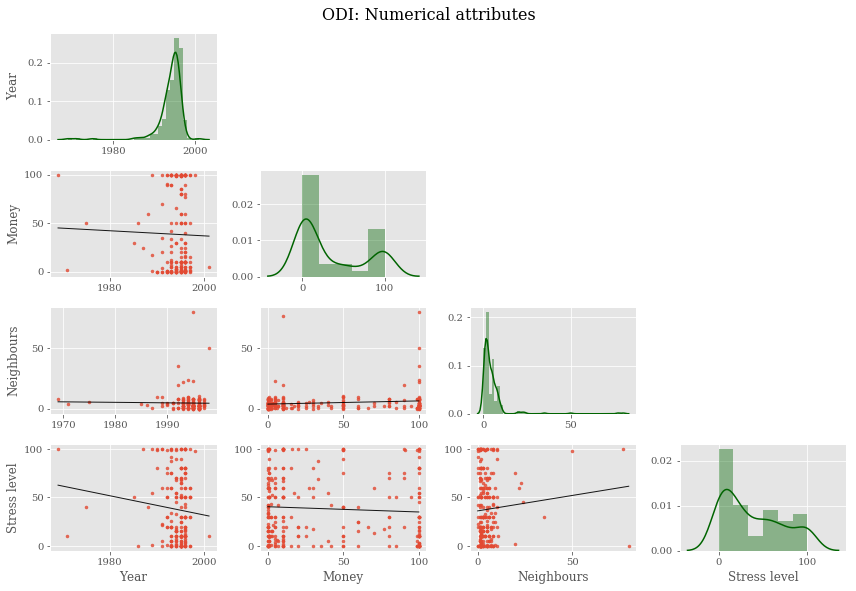

In [18]:
reload(util.plot)
reload(util.data)

util.plot.correlation_grid(data, numerical)
plt.suptitle('ODI: Numerical attributes', y=1.02, fontsize=16)
util.plot.savefig('Correlations-grid')

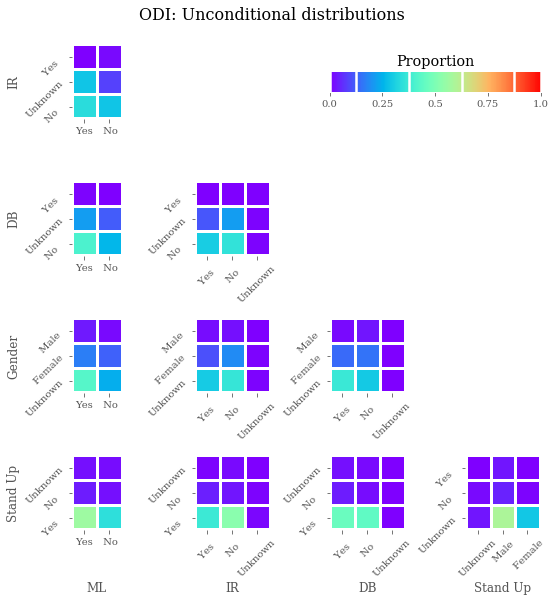

In [19]:
reload(util.plot)
reload(util.data)

cmap = 'rainbow'
keys = categorical.copy()
keys.remove('Chocolate')
keys.remove('Stat')
util.plot.correlation_grid(data, keys, numerical=False, cmap=cmap)
plt.suptitle('ODI: Unconditional distributions', y=1.04, fontsize=16)
util.plot.savefig('Unconditional-distributions-grid')

## Conditional distributions

I.e. the distribution of $Y$ given $X=x$ (for each $x$)

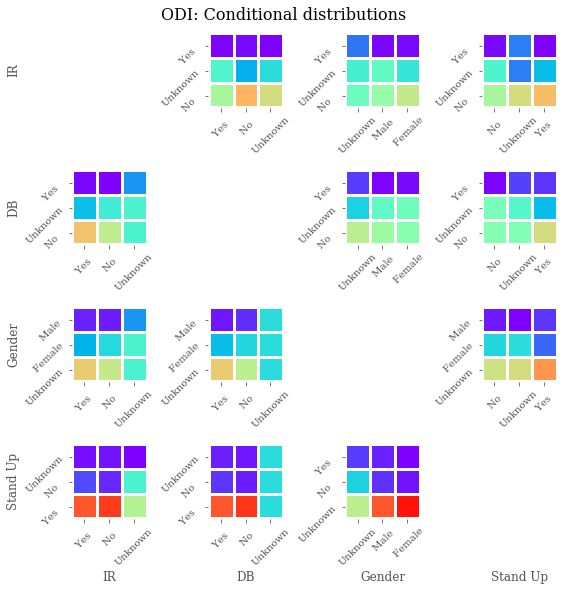

In [20]:
reload(util.plot)
reload(util.data)

keys = categorical.copy()
keys.remove('ML')
keys.remove('Stat')
keys.remove('Chocolate')
util.plot.correlation_grid(data, keys, conditional_x=True, numerical=False, cmap=cmap)
plt.suptitle('ODI: Conditional distributions', y=1.02, fontsize=16)
util.plot.savefig('Conditional-distributions-grid')

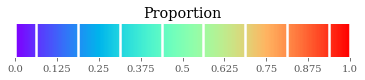

In [21]:
reload(util.plot)

with plt.style.context(('ggplot')):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    util.plot.colormap(cmap, ax, ratio=10, n_xticks=9)
    plt.title('Proportion')

util.plot.savefig('Conditional-distributions-grid-cb')

In [22]:
# plot_correlations(data, categorical, conditional_x=True)
# plt.suptitle('Conditional distributions', fontsize=16)
# util.plot.savefig('Conditional-distributions-grid')

In [84]:
counts = collections.Counter(data["Programme"])
total = sum(studyCounts.values())
# studyCounts['Other'] = 42
most_common = dict(counts.most_common(9))
least_common = counts
for k in most_common.keys():
    least_common.pop(k)

most_common['Other'] = sum(least_common.values())

In [85]:
# # reload(util.string)
# reload(util.plot)
# d = df.to_dict()['count']
# with plt.style.context(('ggplot')):
#     rcParams['font.size'] = 14
#     util.plot.categorical_distribution(d, sort=False)
#     plt.xticks(rotation=75)
#     plt.title('ODI: Programme distribution')
# # util.plot.savefig('Programme-hist')

In [105]:
# best 3
# d = df.to_dict()['count']
# keys, values = zip(*sorted(d.items(), key=lambda x: x[0]))
values = np.array(list(most_common.values()))
values

array([131,  75,  30,  16,   5,   3,   2,   1,   1,  12])

In [123]:
for n in range(1,10):
    proportion = round(sum(values[:n]) / sum(values), n)
    print('%i best: %0.2f' % (n, proportion*100) + '%')

1 best: 50.00%
2 best: 75.00%
3 best: 85.50%
4 best: 91.30%
5 best: 93.12%
6 best: 94.20%
7 best: 94.93%
8 best: 95.29%
9 best: 95.65%


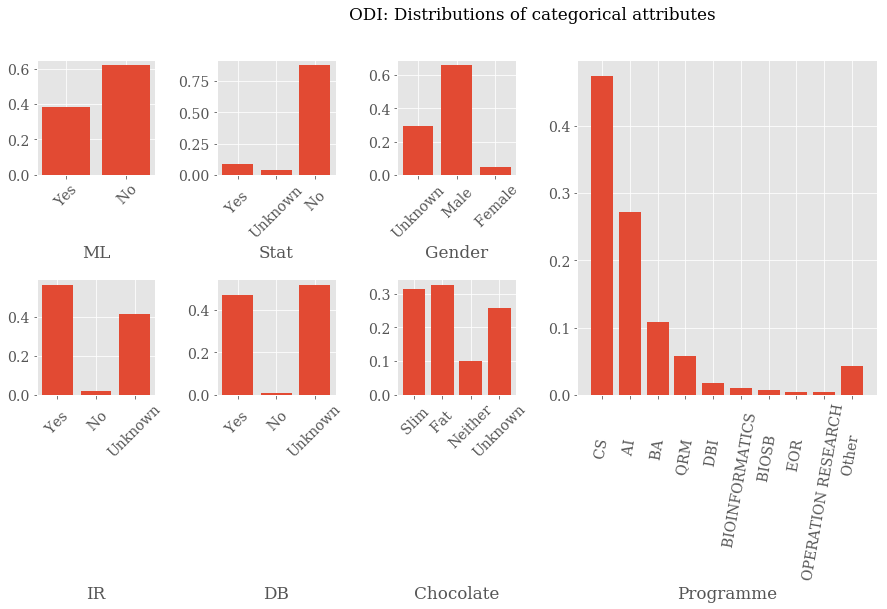

In [124]:
n2 = len(categorical)
# n = np.ceil(n2**0.5)
ij = lambda i,n: (np.floor(i/n), i % n)

with plt.style.context(('ggplot')):
    rcParams['font.size'] = 14
    m = 2
    n = 6
    n_minor = 3 # small plots form a 3x3 grid
    fig = plt.figure(figsize=(m*n+3,n+2))
    for i,k in enumerate(categorical):
        assert i < m*n
        i,j = ij(i, m)
        i = i + j * n + 1
        ax = fig.add_subplot(m, n, i)
        counts = collections.Counter(data[k])
        title = k.title() if len(k) > 2 else k
        util.plot.categorical_distribution(counts, fig, title, label_func=lambda x: x.title())
        plt.xticks(rotation=45)
#         plt.margins(0.1)

    ax = plt.subplot2grid( (m, n), (0, n_minor), rowspan=2, colspan=2)
    util.plot.categorical_distribution(most_common, fig, sort=False)
    plt.xticks(rotation=80)
    plt.xlabel('Programme')
    
    
    fig.align_labels()
    plt.tight_layout()
    plt.suptitle('ODI: Distributions of categorical attributes', y=1.06)

util.plot.savefig('odi-categorical-hist')

In [88]:
counts = collections.Counter(data["DB"])
counts, 3/sum(counts.values()) * 100

(Counter({'Yes': 143, 'No': 130, 'Unknown': 3}), 1.0869565217391304)

In [89]:
counts = collections.Counter(data["Stat"])
counts, 242/sum(counts.values()) * 100

(Counter({'Yes': 242, 'Unknown': 10, 'No': 24}), 87.68115942028986)

In [137]:
# programme = pd.DataFrame.from_dict(most_common, orient='index')
# keys = df['count'].keys()
# keys.drop('Other')
# keys.drop('AI')
programme = data['Programme'].copy()
programme[~programme.isin(keys)] = "Other"
programme[programme.str.contains('Other')]

80     Other
122    Other
139    Other
164    Other
171    Other
202    Other
210    Other
212    Other
217    Other
231    Other
274    Other
Name: Programme, dtype: object

In [142]:
fn = 'ODI-2019-clean'
with open(fn, 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [147]:
# load (old) data from disk
with open(fn, 'rb') as f:
    data_cp = pickle.load(f)

In [146]:
# data_cp.head()